# 阶段0: 环境检测与导入

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import copy
import random
import matplotlib.pyplot as plt
import time
from datasets import load_dataset
import sentencepiece as spm
import tempfile
from datetime import timedelta
from dataclasses import dataclass
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from collections import Counter

In [2]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
  print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# 设置随机种子, 保证可以复现
torch.manual_seed(42)
np.random.seed(42)

GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB


# 阶段1: Embedding


## 1.1 Token Embedding

In [3]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size:int, d_model:int):
    super().__init__()
    self.d_model = d_model
    self.lut = nn.Embedding(vocab_size, d_model) # W_E: (vocab_szie, d_model)
    # X @ W_E 不合法是因为这里不是在做矩阵乘法
    # Y[b, t, :] = W_E(X[b, t, :]) 实际上时在索引

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """
    x: (batch_size, seq_len)
    return: (batch_size, seq_len, d_model)
    """
    return self.lut(x) * math.sqrt(self.d_model)


## 1.2 Positional Encoding

In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model:int, dropout:float=0.0, max_len:int=5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    # position: (max_len, 1)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

    # div_term: (1, d_model/2)
    div_term = torch.exp(
        torch.arange(0, d_model, 2, dtype=torch.float)
        * (-math.log(10000) / d_model)
    ).unsqueeze(0)


    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0) # ->(1, max_len, d_model) 方便与batch相加(广播机制)

    # 注册为buffer
    self.register_buffer("pe", pe)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = x + self.pe[:, :x.size(1)] # x; (batch_size, seq_len, d_modle) 即上面embed的输出
    return self.dropout(x)

# 阶段2: Attention机制

## 1.1 Scaled Dot-Product Attention
$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$


In [5]:
def attention(query, key, value, mask=None, dropout=None):
  """
  计算缩放点积 Scaled Dot-Product Attention
  query: (batch, headi, seq_len_q, d_k)
  key:   (batch, headi, seq_len_k, d_k)
  value: (batch, headi, seq_len_k, d_v)
  mask:  (batch, 1 or headi, seq_len_q, seq_len_k) padding mask or subsequent mask
  output: (batch, h, seq_len_q, seq_len_k)
  """
  d_k = query.size(-1)

  # 1. QK^T / sqrt(kd)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)# scores: (batch, h, seq_q, seq_k)

  # 2. mask(被mask的位置为-inf)
  if mask is not None:
    mask = mask.to(torch.bool)
    scores = scores.masked_fill(~mask, float('-inf'))


  # 3. softmax
  attention_weights = F.softmax(scores, dim=-1)

  # 4.dropout
  if dropout is not None:
    attention_weights = dropout(attention_weights)

  # V的加权求和
  output = torch.matmul(attention_weights, value)

  return output, attention_weights


## 2.2 Multi-Head Attention

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.


In [6]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout=0.0):
    super().__init__()
    assert d_model % num_heads == 0

    self.d_model = d_model
    self.h = num_heads
    self.d_k = d_model // num_heads

    # 四个Linear networks, 每个的大小是(512, 8*64)的
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)
    self.W_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, query, key, value, mask=None):
    batch_size, seq_len_q, _ = query.size()
    seq_len_k = key.size(1)

    # 我们假设d_k == d_v
    assert key.size(1) == value.size(1)

    # 1. 线性映射
    # x;(batch seq_len, d_model) @ W:(d_model, d_model) -> (batch seq_len, d_model)
    Q = self.W_q(query)
    K = self.W_k(key)
    V = self.W_v(value)

    #2. 分头
    Q = Q.view(batch_size, seq_len_q, self.h, self.d_k).transpose(1, 2)
    K = K.view(batch_size, seq_len_k, self.h, self.d_k).transpose(1, 2)
    V = V.view(batch_size, seq_len_k, self.h, self.d_k).transpose(1, 2) # [batch, h, seq_len, d_k]

    # 3. 计算注意力得分
    out, attn = attention(Q, K, V, mask=mask, dropout=self.dropout)

    # 4. 合并
    out = out.transpose(1, 2).contiguous()
    out = out.view(batch_size, seq_len_q, -1) # [batch, seq_len, d_model]

    # 5. 投影
    out = self.W_o(out)

    return out, attn

## 2.3 mask

In [7]:
def make_src_mask(src, pad_idx=0):
  """
  encoder padding mask
  src: (batch, src_seq_len)
  """
  batch_size, seq_len = src.size()
  mask = (src != pad_idx).unsqueeze(1).unsqueeze(2) # mask: (batch, 1, 1, src_seq_len)
  mask = mask.expand(batch_size, 1, seq_len, seq_len).contiguous()
  return mask

def make_tgt_mask(tgt, pad_idx=0):
  """
  decoder padding + subsequent mask
  tgt: (batch, tgt_seq_len)
  """
  batch_size, seq_len = tgt.size()

  # padding mask
  padding_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2) # (batch, 1, 1, tgt_seq_len)
  # subsequent mask
  subsequent_mask = torch.tril(
      torch.ones((seq_len, seq_len), device=tgt.device, dtype=torch.bool)
  ).unsqueeze(0).unsqueeze(0) # (1, 1, tgt_seq_len, tgt_seq_len)

  mask = (padding_mask & subsequent_mask).bool() # (batch, 1, seq_len ,seq_len)

  return mask


def make_cross_attn_mask(src, tgt, pad_idx=0):
  """
  Decoder cross-attention mask
  src: (batch, src_seq_len)
  tgt: (batch, tgt_seq_len)
  return: (batch, 1, tgt_seq_len, src_seq_len)
  """
  batch_size = src.size(0)
  src_len = src.size(1)
  tgt_len = tgt.size(1)

  # Src padding mask: (batch, 1, 1, src_len)
  src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)

  # 扩展到 (batch, 1, tgt_len, src_len)
  mask = src_mask.expand(batch_size, 1, tgt_len, src_len)
  return mask

In [8]:
class Batch:
    # 处理tgt, tgt_y 并计算ntoken
    def __init__(self, src, tgt_input, tgt_y, pad_idx, make_src_mask_fn, make_tgt_mask_fn, make_cross_attn_mask_fn):
        self.src = src
        self.src_mask = make_src_mask_fn(src, pad_idx)
        self.tgt = tgt_input      # [<bos>, y1, y2, y3]
        self.tgt_y = tgt_y     # [y1, y2, y3, <eos>]

        self.tgt_mask = make_tgt_mask_fn(self.tgt, pad_idx)
        self.cross_attn_mask = make_cross_attn_mask_fn(src, self.tgt, pad_idx)
        self.ntokens = (self.tgt_y != pad_idx).sum().item()

# 阶段3: Position-wise FFN

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$


In [9]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff=2048, dropout=0.0):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(p=dropout)

  """
  x = W1x + b1
  x = ReLu(x)
  x = dropout(x)
  x = W2x + b2
  """
  def forward(self, x):
    return self.linear2(
        self.dropout(
            F.relu(self.linear1(x))
        )
    )

# 阶段4: Encoder

## 4.1 Encoder Layer

In [10]:
class LayerNorm(nn.Module):
  def __init__(self, features, eps=1e-6): # features == d_model
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [11]:
class SublayerConnection(nn.Module):
  # 层归一化 + 残差连接 Add&Norm
  def __init__(self, size, dropout):
    super().__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    # sublayer: self-attn or ffn
    return x + self.dropout(sublayer(self.norm(x)))

In [12]:
class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout=0.0):
    super().__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward

    self.sublayer = nn.ModuleList([
        SublayerConnection(size, dropout),
        SublayerConnection(size, dropout)
    ])

    self.size = size

  def forward(self, x, mask):
    # 1. x' = x + self-attention(LN(x))
    x = self.sublayer[0](
        x,
        lambda x: self.self_attn(x, x, x, mask)[0]
    )
    # 2. x' + FFN(LN(x))
    return self.sublayer[1](x, self.feed_forward)


## 4.2 Encoder Stack

In [13]:
class Encoder(nn.Module):
  def __init__(self, layer, N):
    super().__init__()
    self.layers = nn.ModuleList([
      copy.deepcopy(layer) for _ in range(N)
    ])
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

# 阶段5: Decoder

## 5.1 Decoder Layer

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout=0.0):
      super().__init__()
      self.self_attn = self_attn
      self.src_attn = src_attn
      self.feed_forward = feed_forward

      self.sublayer = nn.ModuleList([
          SublayerConnection(size, dropout), # self-attn
          SublayerConnection(size, dropout), # cross-attn
          SublayerConnection(size, dropout), # ffn
      ])

      self.size = size

    def forward(self, x, memory, src_mask, tgt_mask):
      m = memory
      # 1. 第一个子层连接：自注意力机制 x = x + self-attention(LN(x))
      x = self.sublayer[0](
          x,
          lambda x: self.self_attn(x, x, x, tgt_mask)[0]
        )
      # 2. 第二个子层连接：交叉注意力机制 x = x + cross-attention(LN(x))
      x = self.sublayer[1](
          x,
          lambda x: self.src_attn(x, m, m, src_mask)[0]
        )

      # 3. 第三个子层连接：前馈神经网络 x + FFN(LN(x))
      return self.sublayer[2](x, self.feed_forward)

## 2.2 Decoder Stack

In [15]:
class Decoder(nn.Module):
  def __init__(self, layer, N):
    super().__init__()
    self.layers = nn.ModuleList([
        copy.deepcopy(layer) for _ in range(N)
    ])
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

# 阶段6: Generator


In [16]:
# decoder的hidden state转为概率分布
class Generator(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    #return F.log_softmax(self.proj(x), dim=-1)
    return self.proj(x) # logits

# 阶段7: 组装Transformer

In [17]:
class Transformer(nn.Module):
  def __init__(self,
         src_vocab_size,
         tgt_vocab_size,
         d_model,
         d_ff,
         N,
         h,
         dropout):
    super().__init__()
    self.src_vocab_size = src_vocab_size
    self.tgt_vocab_size = tgt_vocab_size
    self.d_model = d_model

    self.src_embed = nn.Sequential(
        Embeddings(src_vocab_size, d_model),
        PositionalEncoding(d_model, dropout)
    )

    self.tgt_embed = nn.Sequential(
        Embeddings(tgt_vocab_size, d_model),
        PositionalEncoding(d_model, dropout)
    )

    self.encoder = Encoder(
        EncoderLayer(d_model,
               MultiHeadAttention(d_model, h),
               PositionwiseFeedForward(d_model, d_ff),
               dropout),
        N
    )

    self.decoder = Decoder(
        DecoderLayer(d_model,
               MultiHeadAttention(d_model, h),
               MultiHeadAttention(d_model, h),
               PositionwiseFeedForward(d_model, d_ff),
               dropout),
        N
    )

    self.generator = Generator(d_model, tgt_vocab_size)
    
    self._init_weights()
    self._tie_weights()

  def _init_weights(self):
    # 初始化模型权重
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

    # 特别处理嵌入层
    nn.init.normal_(self.src_embed[0].lut.weight, mean=0, std=self.d_model ** -0.5)
    nn.init.normal_(self.tgt_embed[0].lut.weight, mean=0, std=self.d_model ** -0.5)


  def _tie_weights(self):
    self.generator.proj.weight = self.tgt_embed[0].lut.weight
    self.generator.proj.weight.requires_grad = True

  def forward(self, src, tgt, src_mask, tgt_mask, cross_attn_mask):
    enc_output = self.encoder(self.src_embed(src), src_mask)
    dec_output = self.decoder(
        self.tgt_embed(tgt),
        enc_output,
        cross_attn_mask,
        tgt_mask
      )

    logits = self.generator(dec_output)
    return logits #(batch, seq_len, tgt_vocab_size)

# 阶段8: Label Smoothing

In [18]:
# class LabelSmoothing(nn.Module):
#     def __init__(self, vocab_size, pad_idx, smoothing=0.1):
#         super().__init__()
#         self.criterion = nn.KLDivLoss(reduction="sum")
#         self.padding_idx = pad_idx
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.size = vocab_size
    
#     def forward(self, x, target):
#         assert x.size(1) == self.size
#         true_dist = x.data.clone()
#         true_dist.fill_(self.smoothing / (self.size - 2))
#         true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#         true_dist[:, self.padding_idx] = 0
#         mask = torch.nonzero(target.data == self.padding_idx)
#         if mask.dim() > 0:
#             true_dist.index_fill_(0, mask.squeeze(), 0.0)
#         return self.criterion(x, true_dist.clone().detach())

# 阶段9 : 优化器

In [19]:
# Warmup: 线性增长
# lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
def make_noam_lambda(d_model, warmup, factor=1.0):
  def rate(step):
    step = max(step, 1)
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )
  return rate

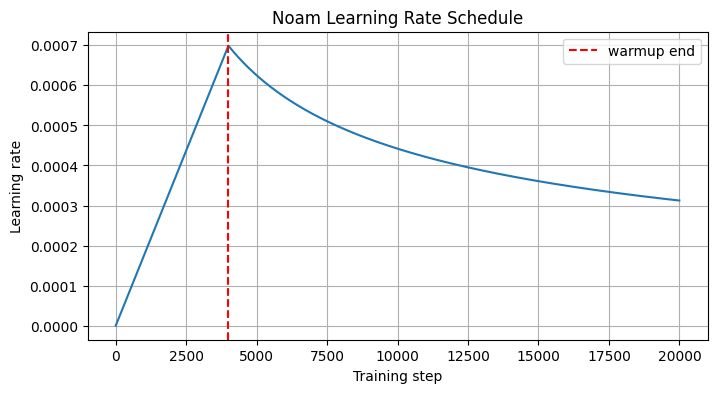

In [20]:
# learning rate warmup可视化
model = torch.nn.Linear(10, 10)

d_model = 512
warmup_steps = 4000

optimizer = Adam(model.parameters(), lr=1.0)
scheduler = LambdaLR(
    optimizer,
    lr_lambda=make_noam_lambda(d_model, warmup_steps)
)

lrs = []

for step in range(1, 20000):
    optimizer.step()
    scheduler.step()     # 更新 lr
    lrs.append(optimizer.param_groups[0]["lr"])

plt.figure(figsize=(8, 4))
plt.plot(lrs)
plt.axvline(warmup_steps, color='r', linestyle='--', label='warmup end')
plt.xlabel("Training step")
plt.ylabel("Learning rate")
plt.title("Noam Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


# 最终阶段： 中英翻译Demo

## 数据处理

In [ ]:
dataset = load_dataset("wmt19", "zh-en", split="train")

sampled_for_step = dataset.shuffle(seed=42).select(range(100000))



# 提取中英文句子并写入临时文件
with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.txt', encoding='utf-8') as f:
    temp_file = f.name
    for item in sampled_for_step:
        # 写入中文句子
        f.write(item['translation']['zh'].strip() + '\n')
        # 写入英文句子
        f.write(item['translation']['en'].strip() + '\n')

print(f"已写入 {len(sampled_for_step)*2} 行文本（中英交替）到临时文件")

# 训练 SentencePiece 模型
spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix="sp16k",
    vocab_size=16000,
    model_type="unigram",
    character_coverage=0.9995,
    pad_id=0, bos_id=1, eos_id=2, unk_id=3,
    shuffle_input_sentence=True,
    num_threads=4
)

# 4. 清理临时文件
os.unlink(temp_file)
print("sp16k.model 构建完成")

# 5. 验证模型
sp = spm.SentencePieceProcessor(model_file="sp16k.model")
PAD, BOS, EOS, UNK = sp.pad_id(), sp.bos_id(), sp.eos_id(), sp.unk_id()
print("词表大小:", sp.get_piece_size())
print("中文分词:", sp.encode("我爱深度学习", out_type=str))
print("英文分词:", sp.encode("I love deep learning", out_type=str))

In [22]:
# 数据处理
def zh_tokenize(sentence):
    return sp.encode(sentence.strip(), out_type=str)

def en_tokenize(sentence):
    return sp.encode(sentence.strip(), out_type=str)

print("中文:", zh_tokenize("我爱深度学习"))      # ['▁我', '爱', '深度', '学习']
print("英文:", en_tokenize("I love deep learning"))  # ['▁I', '▁love', '▁deep', '▁learning']

中文: ['▁我', '爱', '深', '度', '学习']
英文: ['▁I', '▁love', '▁deep', '▁learning']


In [23]:
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, max_src_len=256, max_tgt_len=256):
        self.data = []
        dropped = 0
        
        for zh, en in zip(src_sentences, tgt_sentences):
            # 使用 SP 编码（自动处理 <bos>/<eos>）
            src_ids = sp.encode(zh.strip(), out_type=int)  # list of int
            tgt_ids = sp.encode(en.strip(), out_type=int)
            
            src_ids = [BOS] + src_ids + [EOS]
            tgt_ids = [BOS] + tgt_ids + [EOS]
            
            if len(src_ids) > max_src_len or len(tgt_ids) > max_tgt_len:
                dropped += 1
                continue
            if len(tgt_ids) < 3:
                dropped += 1
                continue

            tgt_input = tgt_ids[:-1]
            tgt_output = tgt_ids[1:]
            
            self.data.append((
                torch.tensor(src_ids),
                torch.tensor(tgt_input),
                torch.tensor(tgt_output)
            ))
        
        print(f"[TranslationDataset] 保留 {len(self.data)} 条样本，丢弃 {dropped} 条超长样本")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
def make_collate_fn(pad_id):
    def collate_fn(batch):
        srcs, tgts_input, tgts_output = zip(*batch)
        srcs_padded = torch.nn.utils.rnn.pad_sequence(
            srcs, batch_first=True, padding_value=pad_id
        )
        tgts_input_padded = torch.nn.utils.rnn.pad_sequence(
            tgts_input, batch_first=True, padding_value=pad_id
        )
        tgts_output_padded = torch.nn.utils.rnn.pad_sequence(
            tgts_output, batch_first=True, padding_value=pad_id
        )
        return srcs_padded, tgts_input_padded, tgts_output_padded
    return collate_fn

## 训练

In [26]:
class SimpleLossCompute: 
    def __init__(self, criterion): 
        self.criterion = criterion

    def __call__(self, x, y, norm):
        """
        x: 模型输出的logits [batch_size, seq_len, tgt_vocab_size]
        y: 目标token [batch_size, seq_len]
        norm: 归一化因子（ntokens）
        """
        batch_size, seq_len, vocab_size = x.shape
        x = x.view(-1, vocab_size)      # -> [N, C]
        y = y.view(-1)                  # -> [N]

        loss = self.criterion(x, y)  # 这是sum reduction的总损失
        
        # 计算平均损失（每个token）
        loss_per_token = loss / norm if norm > 0 else loss
        
        # 返回：(用于记录的标量, 用于反向传播的tensor)
        return loss_per_token.item(), loss_per_token
    
@dataclass
class TrainState: 
    # 跟踪训练状态
    step: int = 0 
    accum_step: int = 0 
    samples: int = 0 
    tokens: int = 0

In [27]:
class BucketSampler(Sampler):
    def __init__(self, dataset, max_tokens, max_batch_size=64, shuffle=True, drop_last=False):
        self.dataset = dataset
        self.max_tokens = max_tokens
        self.max_batch_size = max_batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        
        # 获取所有样本长度（取 source 和 target 的最大值）
        self.lengths = []
        for i in range(len(dataset)):
            src_len = len(dataset[i][0])
            tgt_len = len(dataset[i][1])
            self.lengths.append(src_len + tgt_len)
        
        # 按长度排序索引
        sorted_indices = sorted(range(len(self.lengths)), key=lambda i: self.lengths[i])
        
        # 创建批次
        self.batches = []
        current_batch = []
        current_total_tokens = 0
        
        for idx in sorted_indices:
            seq_len = self.lengths[idx]
            # 估算添加此样本后的总 token 数
            new_total_tokens = current_total_tokens + seq_len
            
            # 如果超过最大 token 数或 batch size 限制，保存当前 batch
            if (new_total_tokens > self.max_tokens or 
                len(current_batch) >= self.max_batch_size) and current_batch:
                self.batches.append(current_batch)
                current_batch = [idx]
                current_total_tokens = seq_len
            else:
                current_batch.append(idx)
                current_total_tokens = new_total_tokens
        
        # 添加最后一批
        if current_batch and (not drop_last or len(current_batch) >= 2):
            self.batches.append(current_batch)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


In [ ]:
import sacrebleu
from typing import List, Tuple, Dict, Any
import heapq

# 质量监控
class ValidationMonitor:
    def __init__(self, sp_processor, device, test_set=None, patience=5, min_epochs=3, beam_size=3):
        self.sp = sp_processor
        self.device = device
        self.patience = patience
        self.min_epochs = min_epochs
        self.beam_size = beam_size
        self.best_bleu = 0.0
        self.wait = 0
        self.history = []
        
        # 参考测试集
        self.test_set = test_set or [
            ("我爱深度学习", "I love deep learning"),
            ("人工智能改变世界", "Artificial intelligence is changing the world"),
            ("今天天气真不错", "The weather is really nice today"),
            ("经济危机不断加深", "The economic crisis is deepening"),
            ("机器学习是人工智能的核心", "Machine learning is the core of artificial intelligence"),
            ("自然语言处理很有趣", "Natural language processing is fascinating"),
            ("深度学习需要大量数据", "Deep learning requires massive amounts of data"),
            ("神经网络模仿人脑工作", "Neural networks mimic the human brain"),
            ("Transformer模型改变了NLP领域", "Transformer models have revolutionized the NLP field"),
            ("注意力机制是关键创新", "The attention mechanism is a key innovation"),
            ("梯度下降优化模型参数", "Gradient descent optimizes model parameters"),
            ("过拟合会导致泛化能力差", "Overfitting leads to poor generalization"),
            ("正则化技术提高模型鲁棒性", "Regularization techniques improve model robustness"),
            ("批量归一化加速训练", "Batch normalization accelerates training"),
            ("残差连接解决梯度消失", "Residual connections solve the vanishing gradient problem"),
            ("词嵌入捕捉语义信息", "Word embeddings capture semantic information"),
            ("序列到序列模型用于机器翻译", "Sequence-to-sequence models are used for machine translation"),
            ("束搜索提高翻译质量", "Beam search improves translation quality"),
            ("自回归生成保证连贯性", "Autoregressive generation ensures coherence"),
            ("多头注意力增强表示能力", "Multi-head attention enhances representation capability")
        ]

        # 预处理参考译文 (分词处理)
        self.ref_sentences = [
            self._preprocess_ref(ref) for _, ref in self.test_set
        ]

    def _preprocess_ref(self, sentence: str) -> str:
        # 英文分词
        tokens = self.sp.encode(sentence.strip(), out_type=str)
        tokens = [t for t in tokens if t not in ['<pad>', '<bos>', '<eos>', '<unk>']]
        return " ".join(tokens).replace("▁", " ").strip()

    def compute_bleu(self, model, src_sentences: List[str], tgt_references: List[str]) -> float:
        model.eval()
        translations = []
        with torch.no_grad():
            for sent in src_sentences:
                # 使用beam search (beam_size=3)
                token_ids = self.beam_decode(model, sent, beam_size=self.beam_size)
                # 转换为文本
                trans_text = self.sp.decode(token_ids)
                translations.append(trans_text)

        processed_trans = [
            self._preprocess_ref(trans) for trans in translations
        ]

        # 计算BLEU
        bleu = sacrebleu.corpus_bleu(
            processed_trans,
            [self.ref_sentences],
            tokenize='none',
            lowercase=True
        )
        return bleu.score
    

    def beam_decode(self, model, sentence: str, beam_size: int = 3, max_len: int = 50) -> List[int]:
        model.eval()
        
        # 1. 编码源句子
        src_ids = self.sp.encode(sentence.strip(), out_type=int)
        src_ids = [self.sp.bos_id()] + src_ids + [self.sp.eos_id()]
        src_tensor = torch.tensor([src_ids], dtype=torch.long, device=self.device)
        
        # 2. 创建mask
        src_mask = make_src_mask(src_tensor, self.sp.pad_id()).to(self.device)
        
        # 3. 初始化beam
        BOS = self.sp.bos_id()
        EOS = self.sp.eos_id()
        PAD = self.sp.pad_id()
        UNK = self.sp.unk_id()
        
        # 每个候选: (log_prob, tokens, finished)
        beams = [(0.0, [BOS], False)]
        finished_beams = []
        
        # 4. 迭代生成
        for step in range(max_len):
            if len(finished_beams) >= beam_size:
                break
                
            # 收集所有未完成候选
            current_inputs = []
            current_beams = []
            
            for log_prob, tokens, finished in beams:
                if not finished:
                    current_inputs.append(tokens)
                    current_beams.append((log_prob, tokens))
            
            if not current_inputs:
                break
                
            # 准备batch输入
            max_len_curr = max(len(tokens) for tokens in current_inputs)
            batch_input = torch.full(
                (len(current_inputs), max_len_curr), 
                PAD, 
                dtype=torch.long, 
                device=self.device
            )
            
            for i, tokens in enumerate(current_inputs):
                batch_input[i, :len(tokens)] = torch.tensor(tokens, device=self.device)
            
            # 创建target mask
            tgt_mask = make_tgt_mask(batch_input, PAD).to(self.device)
            cross_mask = make_cross_attn_mask(src_tensor.repeat(len(current_inputs), 1), batch_input, PAD).to(self.device)
            
            # 模型前向
            with torch.no_grad():
                logits = model(
                    src_tensor.repeat(len(current_inputs), 1),
                    batch_input,
                    src_mask.repeat(len(current_inputs), 1, 1, 1),
                    tgt_mask,
                    cross_mask
                )
            
            # 获取最后一步的logits
            next_logits = logits[:, -1, :]  # [batch_size, vocab_size]
            
            # 应用约束
            next_logits[:, PAD] = -1e9
            next_logits[:, BOS] = -1e9
            next_logits[:, UNK] = -1e9
            
            # 长度惩罚因子 (避免过短序列)
            alpha = 0.7
            
            # 扩展候选
            new_beams = []
            for i, (log_prob, tokens) in enumerate(current_beams):
                # 获取top-k候选 (k = beam_size * 2)
                probs = F.log_softmax(next_logits[i], dim=-1)
                topk_probs, topk_ids = torch.topk(probs, k=beam_size * 2, dim=-1)
                
                for prob, token_id in zip(topk_probs, topk_ids):
                    new_log_prob = log_prob + prob.item()
                    # 长度归一化: (5 + len)^alpha / (5 + 1)^alpha
                    normalized_prob = new_log_prob / ((5 + len(tokens)) ** alpha)
                    
                    new_tokens = tokens + [token_id.item()]
                    finished = (token_id.item() == EOS) or (len(new_tokens) >= max_len)
                    
                    if finished:
                        finished_beams.append((normalized_prob, new_tokens))
                    else:
                        new_beams.append((new_log_prob, new_tokens, False))
            
            # 5. 合并并选择top-k
            beams = heapq.nlargest(beam_size, new_beams, key=lambda x: x[0])
            
            # 6. 检查早停
            if all(finished for _, _, finished in beams):
                break
        
        # 7. 选择最佳完成序列
        if finished_beams:
            best_beam = max(finished_beams, key=lambda x: x[0])[1]
        else:
            best_beam = max(beams, key=lambda x: x[0])[1]
        
        # 移除BOS/EOS/PAD
        return [
            token_id for token_id in best_beam 
            if token_id not in [BOS, EOS, PAD]
        ]
    
def should_stop(self, epoch, val_loss, model):
    src_sents, _ = zip(*self.test_set)
    current_bleu = self.compute_bleu(model, list(src_sents), self.ref_sentences)
    
    # 保存历史
    self.history.append({
        'epoch': epoch,
        'val_loss': val_loss,
        'bleu': current_bleu
    })
    
    # 打印验证结果
    print(f"\n[VAL] Epoch {epoch+1} | Val Loss: {val_loss:.4f} | BLEU-4: {current_bleu:.2f}")
    print(f"Best BLEU so far: {self.best_bleu:.2f}")
    
    # 保存最佳模型条件
    save_model = False
    if current_bleu > self.best_bleu:
        self.best_bleu = current_bleu
        self.wait = 0
        save_model = True
    else:
        self.wait += 1
    
    # 早停条件
    stop_training = False
    if epoch >= self.min_epochs and self.wait >= self.patience:
        stop_training = True
    
    return stop_training, save_model


In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=None,
    PAD=0,
    device=device,
    make_src_mask_fn=make_src_mask,
    make_tgt_mask_fn=make_tgt_mask,
    make_cross_attn_mask_fn=make_cross_attn_mask
):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0

    # 训练模式清零梯度
    if mode == "train" and optimizer is not None:
        optimizer.zero_grad(set_to_none=True)

    for i, batch_data in enumerate(data_iter):
        src = batch_data[0].to(device, non_blocking=True)
        tgt_input = batch_data[1].to(device, non_blocking=True)
        tgt_y = batch_data[2].to(device, non_blocking=True)

        batch = Batch(src, tgt_input, tgt_y, PAD, make_src_mask_fn, make_tgt_mask_fn, make_cross_attn_mask_fn)
        
        # 前向传播 (纯FP32)
        out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask, batch.cross_attn_mask)
        loss_value, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)

        if mode == "train" or mode == "train+log":
            # 反向传播
            loss_node.backward()
            
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens

            if (i + 1) % accum_iter == 0:
                # 梯度裁剪 (防止梯度爆炸)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # 优化器步进
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            
                # 学习率调度
                if scheduler is not None:
                    scheduler.step()

        total_loss += loss_value * batch.ntokens
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 200 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"] if optimizer else 0.0
            elapsed = time.time() - start
            print(
                f"Epoch Step: {i} | Accumulation Step: {n_accum} | "
                f"Loss: {loss_value:.4f} | "
                f"Tokens/Sec: {tokens / elapsed:.0f} | "
                f"Learning Rate: {lr:.8f}"
            )
            start = time.time()
            tokens = 0

    return total_loss / total_tokens, train_state


In [ ]:
def translate(model, sentence, sp_processor, device, beam_size=3, max_len=50):
    #  使用beam search
    model.eval()
    with torch.no_grad():
        # 1. 编码源句子
        src_ids = sp_processor.encode(sentence.strip(), out_type=int)
        src_ids = [sp_processor.bos_id()] + src_ids + [sp_processor.eos_id()]
        
        # 2. 使用Beam Search (复用ValidationMonitor)
        monitor = ValidationMonitor(sp_processor, device, beam_size=beam_size)
        token_ids = monitor.beam_decode(model, sentence, beam_size=beam_size, max_len=max_len)
        
        # 3. 转换为文本
        return sp_processor.decode(token_ids)

def evaluate(model, sp_processor, device, epoch, val_monitor):
    # 使用BLEU评估翻译质量
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1} 翻译质量评估")
    print(f"{'='*50}")
    
    model.eval()
    with torch.no_grad():
        # 计算当前BLEU
        src_sents, _ = zip(*val_monitor.test_set)
        bleu_score = val_monitor.compute_bleu(model, list(src_sents), val_monitor.ref_sentences)
        
        # 打印关键样本
        print(f"BLEU-4 Score: {bleu_score:.2f}")
        print("\n关键样本翻译:")
        for sent in ["我爱深度学习", "人工智能改变世界", "经济危机不断加深"]:
            translation = translate(model, sent, sp_processor, device, beam_size=3)
            print(f"【{sent}】 → {translation}")
    
    model.train()
    return bleu_score


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    num_epochs=30,
    accum_iter=2,
    device=device,
    PAD=0,
    val_monitor=None
):
    # 创建loss compute
    loss_compute = SimpleLossCompute(criterion)
    
    # 训练状态
    train_state = TrainState()
    
    # 验证监控
    if val_monitor is None:
        val_monitor = ValidationMonitor(sp, device, beam_size=3, patience=5, min_epochs=8)
    
    best_bleu = 0.0
        
    # 重置 scheduler 状态
    if scheduler is not None:
        scheduler.last_epoch = -1  # 重置 step 计数器

    for epoch in range(num_epochs):
        if epoch == 0:
            print("Initial parameter ranges:")
            for name, param in model.named_parameters():
                if param.numel() > 0:
                    print(f"{name}: min={param.min().item():.4f}, max={param.max().item():.4f}")
                    
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*80}")
        
        # 训练
        model.train()
        train_loss, train_state = run_epoch(
            train_loader,
            model,
            loss_compute,
            optimizer,
            scheduler,
            mode="train+log",
            accum_iter=accum_iter,
            train_state=train_state,
            PAD=PAD,
            device=device,
            make_src_mask_fn=make_src_mask,
            make_tgt_mask_fn=make_tgt_mask,
            make_cross_attn_mask_fn=make_cross_attn_mask
        )
        
        # 验证
        model.eval()
        with torch.no_grad():
            val_loss, _ = run_epoch(
                val_loader,
                model,
                loss_compute,
                None,
                None,
                mode="eval",
                accum_iter=1,
                PAD=PAD,
                device=device,
                make_src_mask_fn=make_src_mask,
                make_tgt_mask_fn=make_tgt_mask,
                make_cross_attn_mask_fn=make_cross_attn_mask
            )
        
        print(f"\nEpoch {epoch+1} 完成:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        
        # BLEU评估和早停
        stop_training, save_model = val_monitor.should_stop(epoch, val_loss, model)
        
        # 保存最佳模型
        if save_model:
            best_bleu = val_monitor.best_bleu
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'bleu': best_bleu,
                'train_state': train_state,
                'config': config
            }, 'best_model.pt')
            print(f"保存新最佳模型 (BLEU: {best_bleu:.2f})")
        
        if stop_training:
            print(f"\n早停触发! 最佳BLEU: {best_bleu:.2f} @ epoch {epoch+1}")
            break
        
        # 定期展示翻译示例
        if epoch % 2 == 0:
            evaluate(model, sp, device, epoch, val_monitor)
    
    return train_state

In [ ]:
# 划分数据
subset_size = min(100000, len(dataset))
zh_sentences = [item['translation']['zh'] for item in dataset.select(range(subset_size))]
en_sentences = [item['translation']['en'] for item in dataset.select(range(subset_size))]
print(f"原始数据: {len(zh_sentences)} 条")

train_size = int(0.95 * len(zh_sentences))
zh_train, en_train = zh_sentences[:train_size], en_sentences[:train_size]
zh_val, en_val = zh_sentences[train_size:], en_sentences[train_size:]

src_vocab_size = tgt_vocab_size = sp.get_piece_size()
print(f"词表大小: {src_vocab_size}")  # 应为 16000

src_id2tok = {i: sp.id_to_piece(i) for i in range(src_vocab_size)}
tgt_id2tok = {i: sp.id_to_piece(i) for i in range(tgt_vocab_size)}

# 创建数据集
train_dataset = TranslationDataset(zh_train, en_train)
val_dataset = TranslationDataset(zh_val, en_val)
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")

TRAIN_TOKENS_PER_BATCH = 2048    # 训练时每batch目标token数
VAL_TOKENS_PER_BATCH = 4096    # 验证时更大batch (无梯度计算)

# 创建collate函数
collate_fn = make_collate_fn(PAD)

# 创建BucketSampler
train_sampler = BucketSampler(
    train_dataset, 
    max_tokens=2048, 
    shuffle=True,
    drop_last=True
)

val_sampler = BucketSampler(
    val_dataset, 
    max_tokens=2048,
    shuffle=False,
    drop_last=False
)

# 创建DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    collate_fn=collate_fn,
)

# 创建验证监控器
val_monitor = ValidationMonitor(sp, device, beam_size=3, patience=5, min_epochs=8)

print(f"训练批次数: {len(train_loader)} (动态batch)")
print(f"验证批次数: {len(val_loader)}")
print(f"训练集样本分布: 最短={min(len(train_dataset[i][0]) for i in range(len(train_dataset)))} tokens, "
      f"最长={max(len(train_dataset[i][0]) for i in range(len(train_dataset)))} tokens")

# 检查一个batch示例
sample_batch = next(iter(train_loader))
print(f"示例batch形状: src={sample_batch[0].shape}, tgt_input={sample_batch[1].shape}, tgt_output={sample_batch[2].shape}")
print(f"实际batch tokens数: {sample_batch[0].shape[0] * sample_batch[0].shape[1]}")

原始数据: 100000 条
词表大小: 16000
[TranslationDataset] 保留 95000 条样本，丢弃 0 条超长样本
[TranslationDataset] 保留 5000 条样本，丢弃 0 条超长样本
训练集大小: 95000
验证集大小: 5000
训练批次数: 3025 (动态batch)
验证批次数: 161
训练集样本分布: 最短=3 tokens, 最长=193 tokens
示例batch形状: src=torch.Size([37, 30]), tgt_input=torch.Size([37, 35]), tgt_output=torch.Size([37, 35])
实际batch tokens数: 1110


In [36]:
# 超参数
config = {
    'd_model': 256,
    'd_ff': 1024,
    'h': 4,
    'N': 4,
    'dropout': 0.1,
    'lr': 1.0,
    'weight_decay':1e-4,
    'warmup_steps': 4000,
    'accumulation_steps': 4,
    'factor': 1.0,
}

model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=config['d_model'],
    d_ff=config['d_ff'],
    N=config['N'],
    h=config['h'],
    dropout=config['dropout']
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=config['weight_decay']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=make_noam_lambda(
        d_model=config['d_model'],
        warmup=config['warmup_steps'],
        factor=config['factor']
    )
)

criterion = nn.CrossEntropyLoss(
    ignore_index=PAD, 
    label_smoothing=0.1,
    reduction="sum"
)

print(f"d_model: {config['d_model']}")
print(f"d_ff: {config['d_ff']}")
print(f"num_heads: {config['h']}")
print(f"num_layers: {config['N']}")
print(f"dropout: {config['dropout']}")
print(f"warmup_steps: {config['warmup_steps']}")

d_model: 256
d_ff: 1024
num_heads: 4
num_layers: 4
dropout: 0.1
warmup_steps: 4000


In [ ]:
# 启动训练
train_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=30,
    accum_iter=config['accumulation_steps'],
    device=device,
    PAD=PAD,
    val_monitor=val_monitor
)

Initial parameter ranges:
src_embed.0.lut.weight: min=-0.3115, max=0.3094
tgt_embed.0.lut.weight: min=-0.3079, max=0.3261
encoder.layers.0.self_attn.W_q.weight: min=-0.1083, max=0.1082
encoder.layers.0.self_attn.W_q.bias: min=-0.0622, max=0.0620
encoder.layers.0.self_attn.W_k.weight: min=-0.1083, max=0.1082
encoder.layers.0.self_attn.W_k.bias: min=-0.0624, max=0.0620
encoder.layers.0.self_attn.W_v.weight: min=-0.1082, max=0.1082
encoder.layers.0.self_attn.W_v.bias: min=-0.0624, max=0.0617
encoder.layers.0.self_attn.W_o.weight: min=-0.1083, max=0.1082
encoder.layers.0.self_attn.W_o.bias: min=-0.0625, max=0.0611
encoder.layers.0.feed_forward.linear1.weight: min=-0.0685, max=0.0685
encoder.layers.0.feed_forward.linear1.bias: min=-0.0624, max=0.0625
encoder.layers.0.feed_forward.linear2.weight: min=-0.0685, max=0.0685
encoder.layers.0.feed_forward.linear2.bias: min=-0.0312, max=0.0308
encoder.layers.0.sublayer.0.norm.a_2: min=1.0000, max=1.0000
encoder.layers.0.sublayer.0.norm.b_2: min=0.0

In [ ]:
# 翻译推理
checkpoint = torch.load('best_model.pt', weights_only=False, map_location=device)
print(f"加载的模型来自 Epoch {checkpoint['epoch']}")
print(f"训练损失: {checkpoint['train_loss']:.4f}")
print(f"验证损失: {checkpoint['val_loss']:.4f}")

test_model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=config['d_model'],
    d_ff=config['d_ff'],
    N=config['N'],
    h=config['h'],
    dropout=config['dropout']
).to(device)

test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

test_sentences = [
    "我爱深度学习",
    "人工智能改变世界", 
    "今天天气真不错",
    "经济危机不断加深"
]

for sent in test_sentences:
    # 假设有final_model（内存里的最后的model）
    final_translation = translate(model, sent, sp, device)
    best_translation = translate(test_model, sent, sp, device)

    print(f"输入: {sent}")
    print(f"final_model输出: {final_translation}")
    print(f"earlystop_model输出: {best_translation}\n")


加载的模型来自 Epoch 14
训练损失: 0.0031
验证损失: 0.0032
输入: 我爱深度学习
final_model输出: I love Deep learning
earlystop_model输出: I love Deep learning

输入: 人工智能改变世界
final_model输出: artificial intelligence Change the World
earlystop_model输出: AI Change the World

输入: 今天天气真不错
final_model输出: Today’s weather Help
earlystop_model输出: Today’s weather True

输入: 经济危机不断加深
final_model输出: The Economic Crisis continues to deepen
earlystop_model输出: Economic Crisis deepens

